# Feature Engineering and Model Training for Per-Query Optimization

This notebook goes through the process of feature engineering based on the query set used for the global hybrid search optimization notebook.

It tries out different feature combinations and model types to identify a useful way forward towards optimizing queries dynamically.

Notes:

* `searcharray` produced an error with numpy version 2.1.2
* Make sure to use `numpy==1.26.4`

Error fixed in the meantime (not verified)

In [1]:
import pandas as pd
import math
import string
import requests
import json
from searcharray import SearchArray
import numpy as np
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.notebook import tqdm_notebook

In [2]:
df_metrics = pd.read_csv('../data/metrics_5000_queries-2024-11-04.csv')

In [3]:
df_metrics[df_metrics['metric'] == 'ndcg'].head(3)

,query,pipeline,metric,value
330000,#8 tags without string,l2arithmetic_mean0.0,ndcg,0.078872
330001,#8 tags without string,l2arithmetic_mean0.1,ndcg,0.078872
330002,#8 tags without string,l2arithmetic_mean0.2,ndcg,0.078872


In [4]:
indexes = df_metrics[df_metrics['metric'] == 'ndcg'].groupby(by='query')['value'].idxmax()
df_filtered = df_metrics.loc[indexes, ['query','pipeline', 'value']]
df_filtered.reset_index(inplace=True, drop=True)

In [5]:
df_filtered.head(3)

,query,pipeline,value
0,#8 tags without string,l2arithmetic_mean0.8,0.481147
1,$1 dollar toys not fidgets,l2arithmetic_mean1.0,0.021742
2,$30 roblox gift card not digital,l2arithmetic_mean1.0,0.082293


## Get 'neuralness' of a Query

`neuralness` is the weight of the neural query extracted by the pipeline name that was used to generate the NDCG value.

In [6]:
def get_neuralness(pipeline):
    keywordness = pipeline[-3:]

    try:
        neuralness = 1 - float(keywordness)
        return neuralness
    except ValueError:
        print("ERROR")
        return math.nan

In [7]:
df_filtered['neuralness'] = df_filtered.pipeline.apply(get_neuralness)

In [8]:
df_filtered = df_filtered.drop(columns=['pipeline'])

In [9]:
df_filtered.columns = ['query_string', 'ndcg', 'neuralness']

In [10]:
df_filtered.head(3)

,query_string,ndcg,neuralness
0,#8 tags without string,0.481147,0.2
1,$1 dollar toys not fidgets,0.021742,0.0
2,$30 roblox gift card not digital,0.082293,0.0


## Query Feature Functions

`num_of_terms`: we expect the number of query terms to be a good feature because the more query terms used the more specific a query is.

`query_length`: we expect the query length (number of characters) to be a good feature because the longer a query is the more specific it is.

`has_numbers`: we expect the presence of numbers/digits to be a good feature because numbers may point towards specific queries.

`has_special_char`: we expect the presence of special characters (non-alphanumeric characters) to be a good feature because that may point towards specific queries. 

In [11]:
def num_of_terms(query_string):
    terms = query_string.split(" ")
    return len(terms)

def query_length(query_string):
    return len(query_string)

def has_numbers(query_string):
    return int(any(char.isdigit() for char in query_string))

def has_special_char(query_string):
    # Define special characters (all non-alphanumeric characters)
    special_chars = string.punctuation
    # Return True if any character in the string is a special character
    return int(any(char in special_chars for char in query_string))

In [12]:
df_filtered['num_of_terms'] = df_filtered.query_string.apply(num_of_terms)
df_filtered['query_length'] = df_filtered.query_string.apply(query_length)
df_filtered['has_numbers'] = df_filtered.query_string.apply(has_numbers)
df_filtered['has_special_char'] = df_filtered.query_string.apply(has_special_char)

In [13]:
df_filtered.head(5)

,query_string,ndcg,neuralness,num_of_terms,query_length,has_numbers,has_special_char
0,#8 tags without string,0.481147,0.2,4,22,1,1
1,$1 dollar toys not fidgets,0.021742,0.0,5,26,1,1
2,$30 roblox gift card not digital,0.082293,0.0,6,32,1,1
3,$60 ps4 that’s not gonna be on amazon,0.000000,1.0,8,37,1,1
4,'m team jesus i'm not religious shirt,0.409661,1.0,7,37,0,1


## Result Feature Functions

`num_results_kw_search`: the number of results for the keyword query.

`max_doc_score`: max score of the retrieved top 10 titles. The scores are BM25 scores calculated individually per result set. That means that the document frequencies of terms is not calculated on the whole index but only on the retrieved subset for the query, making the scores more comparable to each other.

`sum_of_doc_scores`: we use the sum of the scores (and no average value) as an aggregate to have a measure of how relevant all retrieved top 10 titles are.

`get_semantic_scores_for_query`: retrieves the semantic scores for the neural query for the top 10. We store the maximum and the mean as result features.

### Helper functions

`get_titles_for_query`: retrieves the titles of the keyword matches for later score calculation

`whitespace_to_lower`: tokenizes and lowercases text

`get_model_id`: to run a neural search to get the semantic scores we need to know the id of the available model in OpenSearch


### Get Number of Results for Keyword Search

In [14]:
def num_results_kw_search(query_string):
    url = "http://localhost:9200/ecommerce/_search"

    headers = {
        'Content-Type': 'application/json'
    }
    
    
    
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ]
      },
      "query": {
        "multi_match" : {
          "type":       "best_fields",
          "fields":     [
            "product_id^100",
            "product_bullet_point^3",
            "product_color^2",
            "product_brand^5",
            "product_description",
            "product_title^10"
          ],
          "operator":   "and",
          "query":      query_string
        }
      },
      "track_total_hits": "true"
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    num_results = response['hits']['total']['value']
    return num_results

In [15]:
def get_titles_for_query(query_string):
    url = "http://localhost:9200/ecommerce/_search"

    headers = {
        'Content-Type': 'application/json'
    }
      
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ],
        "includes": "product_title"
      },
      "query": {
        "multi_match" : {
          "type":       "best_fields",
          "fields":     [
            "product_id^100",
            "product_bullet_point^3",
            "product_color^2",
            "product_brand^5",
            "product_description",
            "product_title^10"
          ],
          "operator":   "and",
          "query":      query_string
        }
      },
      "track_total_hits": "true"
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    titles = []
    num_results = response['hits']['total']['value']
    if num_results > 0:
        # get all titles
        titles = [item['_source']['product_title'] for item in response['hits']['hits']]

    df = pd.DataFrame(titles, columns=['title'])

    return df

In [16]:
tqdm_notebook.pandas()
df_filtered['num_results'] = df_filtered.query_string.progress_apply(num_results_kw_search)

  0%|          | 0/5000 [00:00<?, ?it/s]

### Tokenizer Definition

We define a simple tokenizer that splits on whitespaces and lowercases.

In [17]:
def whitespace_to_lower(text):
    split = text.lower().split()
    return [token
        for token in split]

ToDo: make the following functions more efficient.

The following functions contain redundant code and only differ in the return value.

In [18]:
# we use searcharray to calculate the highest title score among the retrieved docs
def max_doc_score(df, query):
    # if we retrieved zero docs we return 0 as the max score
    if df.shape[0] == 0:
        return 0
    else:
        # index the titles with the defined tokenizer
        df['title_indexed'] = SearchArray.index(df['title'], tokenizer=whitespace_to_lower)
        # tokenize the query with the same tokenizer
        tokenized_query = df['title_indexed'].array.tokenizer(query)
        # calculate the score for each query term
        # the result is a matrix with number of titles x number of query term dimensions
        scores = np.asarray([df['title_indexed'].array.score(query_term)
                                    for query_term in tokenized_query])
        # calculate the sum of all query terms per title
        sums = [sum(group) for group in zip(*scores)]
        # return the maximum
        return max(sums)

# we use searcharray to calculate the sum of all title scores among the retrieved docs
def sum_of_doc_scores(df, query):
    # if we retrieved zero docs we return 0 as the max score
    if df.shape[0] == 0:
        return 0
    else:
        # index the titles with the defined tokenizer
        df['title_indexed'] = SearchArray.index(df['title'], tokenizer=whitespace_to_lower)
        # tokenize the query with the same tokenizer
        tokenized_query = df['title_indexed'].array.tokenizer(query)
        # calculate the score for each query term
        # the result is a matrix with number of titles x number of query term dimensions
        scores = np.asarray([df['title_indexed'].array.score(query_term)
                                    for query_term in tokenized_query])
        # calculate the sum of all query terms per title
        sums = [sum(group) for group in zip(*scores)]
        # return the sum of all title scores
        return sum(sums)

### Get Semantic Scores

First we get the model id, then we use the model id in the query to retrieve the semantic scores.

In [19]:
# Get model_id
# We are assuming that the installation has only one model. Change this if you have more models 
# and need to pick a specific one

def get_model_id():
    url = "http://localhost:9200/_plugins/_ml/models/_search"
    
    headers = {
        'Content-Type': 'application/json'
    }
    
    payload = {
      "query": {
        "match_all": {}
      },
      "size": 1
    }
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))

    return response.json()['hits']['hits'][0]['_source']['model_id']

model_id = get_model_id()

In [20]:
def get_semantic_scores_for_query(query_string):
    url = "http://localhost:9200/ecommerce/_search"

    headers = {
        'Content-Type': 'application/json'
    }
    
    
    
    payload = {
      "_source": {
        "excludes": [
          "title_embedding"
        ],
        "includes": "product_title"
      },
      "query": {
        "neural": {
          "title_embedding": {
            "query_text": query_string,
            "k": 100,
            "model_id": model_id
          }
        }
      },
      "size": 10
    }
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload)).json()
    titles = []
    num_results = response['hits']['total']['value']
    if num_results > 0:
        # get all titles
        scores = [item['_score'] for item in response['hits']['hits']]

    return scores

In [21]:
import logging, sys
logging.disable(sys.maxsize)

In [22]:
tqdm_notebook.pandas()
df_filtered['max_title_score'] = df_filtered['query_string'].progress_apply(lambda q: max_doc_score(get_titles_for_query(q), q))
df_filtered['sum_title_scores'] = df_filtered['query_string'].progress_apply(lambda q: sum_of_doc_scores(get_titles_for_query(q), q))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
#df_filtered['max_title_score'] = df_filtered['query_string'].apply(lambda q: max_doc_score(get_titles_for_query(q), q))
#df_filtered['sum_title_scores'] = df_filtered['query_string'].apply(lambda q: sum_of_doc_scores(get_titles_for_query(q), q))

2024-11-04 09:24:47,643 - searcharray.indexing - INFO - Indexing begins w/ 4 workers
2024-11-04 09:24:47,644 - searcharray.indexing - INFO - 0 Batch Start tokenization
2024-11-04 09:24:47,644 - searcharray.indexing - INFO - Tokenizing 10 documents
2024-11-04 09:24:47,645 - searcharray.indexing - INFO - Tokenization -- vstacking
2024-11-04 09:24:47,646 - searcharray.indexing - INFO - Tokenization -- DONE
2024-11-04 09:24:47,648 - searcharray.indexing - INFO - Inverting docs->terms
2024-11-04 09:24:47,648 - searcharray.indexing - INFO - Encoding positions to bit array
2024-11-04 09:24:47,650 - searcharray.indexing - INFO - Batch tokenization complete
2024-11-04 09:24:47,650 - searcharray.indexing - INFO - (main thread) Processing 1 batch results
2024-11-04 09:24:47,651 - searcharray.indexing - INFO - Indexing from tokenization complete
2024-11-04 09:24:47,659 - searcharray.indexing - INFO - Indexing begins w/ 4 workers
2024-11-04 09:24:47,659 - searcharray.indexing - INFO - 0 Batch Start

In [23]:
tqdm_notebook.pandas()
df_filtered['max_semantic_score'] = df_filtered['query_string'].progress_apply(lambda q: max(get_semantic_scores_for_query(q)))
df_filtered['avg_semantic_score'] = df_filtered['query_string'].progress_apply(lambda q: np.mean(get_semantic_scores_for_query(q)))

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [27]:
#df_filtered['max_semantic_score'] = df_filtered['query_string'].apply(lambda q: max(get_semantic_scores_for_query(q)))
#df_filtered['avg_semantic_score'] = df_filtered['query_string'].apply(lambda q: np.mean(get_semantic_scores_for_query(q)))

In [24]:
df_filtered.head(5)

,query_string,ndcg,neuralness,num_of_terms,query_length,has_numbers,has_special_char,num_results,max_title_score,sum_title_scores,max_semantic_score,avg_semantic_score
0,#8 tags without string,0.481147,0.2,4,22,1,1,18,0.196224,1.427612,0.488619,0.481962
1,$1 dollar toys not fidgets,0.021742,0.0,5,26,1,1,3,0.225544,0.415382,0.608848,0.594967
2,$30 roblox gift card not digital,0.082293,0.0,6,32,1,1,0,0.000000,0.000000,0.723621,0.690628
3,$60 ps4 that’s not gonna be on amazon,0.000000,1.0,8,37,1,1,0,0.000000,0.000000,0.544553,0.527403
4,'m team jesus i'm not religious shirt,0.409661,1.0,7,37,0,1,0,0.000000,0.000000,0.891805,0.840608


In [25]:
df_filtered.columns

Index(['query_string', 'ndcg', 'neuralness', 'num_of_terms', 'query_length',
       'has_numbers', 'has_special_char', 'num_results', 'max_title_score',
       'sum_title_scores', 'max_semantic_score', 'avg_semantic_score'],
      dtype='object')

In [26]:
# rename the columns
df_filtered = df_filtered.rename(columns={"num_of_terms": "f_1_num_of_terms",
                            "query_length": "f_2_query_length",
                            "has_numbers": "f_3_has_numbers",
                            "has_special_char": "f_4_has_special_char",
                            "num_results": "f_5_num_results",
                            "max_title_score": "f_6_max_title_score",
                            "sum_title_scores": "f_7_sum_title_scores",
                            "max_semantic_score": "f_8_max_semantic_score",
                            "avg_semantic_score": "f_9_avg_semantic_score"
                           })

In [27]:
df_filtered.head(5)

,query_string,ndcg,neuralness,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
0,#8 tags without string,0.481147,0.2,4,22,1,1,18,0.196224,1.427612,0.488619,0.481962
1,$1 dollar toys not fidgets,0.021742,0.0,5,26,1,1,3,0.225544,0.415382,0.608848,0.594967
2,$30 roblox gift card not digital,0.082293,0.0,6,32,1,1,0,0.000000,0.000000,0.723621,0.690628
3,$60 ps4 that’s not gonna be on amazon,0.000000,1.0,8,37,1,1,0,0.000000,0.000000,0.544553,0.527403
4,'m team jesus i'm not religious shirt,0.409661,1.0,7,37,0,1,0,0.000000,0.000000,0.891805,0.840608


In [28]:
# write features
df_filtered.to_csv('features_5000_queries.csv', index=False)

## Explore Random Forest Regression Models with Different Feature Combinations

In [82]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]

y = df_filtered['neuralness']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
model = RandomForestRegressor(random_state=42)

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize variables to track the best combination
best_score = float('inf')
best_combination = None
best_metrics = {}
df_metrics = []

# Try all feature combinations of length 2 to 9
for r in tqdm_notebook(range(2, len(feature_columns) + 1)):
    for combo in combinations(feature_columns, r):
        X = df_filtered[list(combo)]  # Select current feature subset
        
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=cv)
        rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)
        
        # Calculate the mean metrics for the current combination
        mean_score = scores.mean()
        std_score = scores.std()
        mean_rmse = -np.mean(rmse_scores)  # Since RMSE scorer is negative for minimization

        # does the current combination contain keyword search features
        keyword_b = any(feature in combo for feature in kws_features)
        # does the current combination contain neural search features
        neural_b = any(feature in combo for feature in neural_search_features)
        # does the current combination contain query features
        query_b = any(feature in combo for feature in query_features)
        
        df_metrics.append(pd.DataFrame({
            "features": [combo]*5,
            "scores": scores,
            "rmse_scores": rmse_scores,
            "keyword_f": [keyword_b]*5,
            "neural_f": [neural_b]*5,
            "query_f": [query_b]*5,
            }))
        # Update if the current combination is better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_combination = combo
            best_metrics = {
                'Accuracy (mean)': mean_score,
                'Accuracy (std dev)': std_score,
                'RMSE (mean)': mean_rmse
            }
df_metrics = pd.concat(df_metrics)
# Output the best feature combination and its metrics
print("Best Feature Combination:", best_combination)
print("Best Metrics:")
print(f"Accuracy (mean): {best_metrics['Accuracy (mean)']}")
print(f"Accuracy (std dev): {best_metrics['Accuracy (std dev)']}")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

  0%|          | 0/8 [00:00<?, ?it/s]

Best Feature Combination: ('f_1_num_of_terms', 'f_2_query_length', 'f_3_has_numbers', 'f_4_has_special_char', 'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores', 'f_8_max_semantic_score', 'f_9_avg_semantic_score')
Best Metrics:
Accuracy (mean): 0.006651425990352777
Accuracy (std dev): 0.012332085704952955
Cross-Validation RMSE (mean): 0.35973571549845806


In [83]:
df_metrics.head(3)

,features,scores,rmse_scores,keyword_f,neural_f,query_f
0,"(f_1_num_of_terms, f_2_query_length)",-0.027456,-0.368918,False,False,True
1,"(f_1_num_of_terms, f_2_query_length)",-0.039072,-0.367667,False,False,True
2,"(f_1_num_of_terms, f_2_query_length)",-0.014154,-0.363578,False,False,True


In [84]:
df_metrics['rmse_scores'] = df_metrics.rmse_scores.apply(lambda x: (-1)*x)
df_metrics['features'] =  df_metrics.features.apply(lambda x: ','.join(x))

We have five rows per feature combination for the 5-fold cross-validation we ran

In [85]:
df_metrics.head(6)

,features,scores,rmse_scores,keyword_f,neural_f,query_f
0,"f_1_num_of_terms,f_2_query_length",-0.027456,0.368918,False,False,True
1,"f_1_num_of_terms,f_2_query_length",-0.039072,0.367667,False,False,True
2,"f_1_num_of_terms,f_2_query_length",-0.014154,0.363578,False,False,True
3,"f_1_num_of_terms,f_2_query_length",-0.028307,0.368868,False,False,True
4,"f_1_num_of_terms,f_2_query_length",-0.057388,0.365424,False,False,True
0,"f_1_num_of_terms,f_3_has_numbers",-0.000961,0.364130,False,False,True


## Metric Aggregation

We want to look at different visualizations to analyze differences in feature combinations and also model types.

In [86]:
df_agg_metrics = df_metrics.groupby(by=['features', 'keyword_f', 'neural_f', 'query_f']).agg({
    'rmse_scores': ['mean', 'var']
}).reset_index()

In [87]:
df_agg_metrics.columns = ['features', 'keyword_f', 'neural_f', 'query_f', 'mean_rmse', 'var_rmse']

In [88]:
pd.set_option("display.max_colwidth", 250)

In [89]:
df_agg_metrics.sort_values(by='mean_rmse').head(5)

,features,keyword_f,neural_f,query_f,mean_rmse,var_rmse
7,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.359736,0.000005
38,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.360171,0.000007
192,"f_1_num_of_terms,f_4_has_special_char",False,False,True,0.360236,0.000010
41,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.360436,0.000013
134,"f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.360465,0.000016


### Show the best ten feature combinations based on the mean root squared error

Visualize the different rmse scores in a boxplot to see how different the single cross validation runs scored.

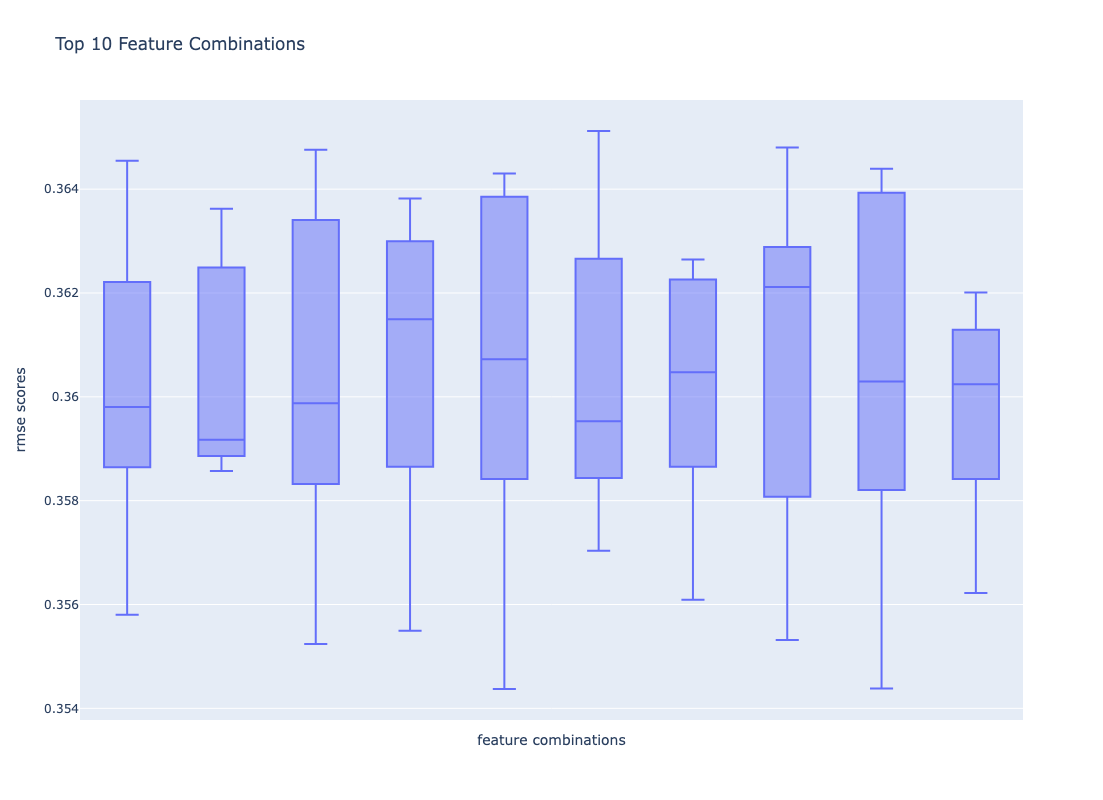

In [90]:
pio.renderers.default = 'plotly_mimetype'
x = df_agg_metrics.sort_values(by='mean_rmse')['features'].head(10)

fig = px.box(df_metrics, x=df_metrics[df_metrics['features'].isin(x)]['features'],
             y=df_metrics[df_metrics['features'].isin(x)]['rmse_scores'], title='RMSE Boxplot of Top 10 Feature Combinations')
fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

### Show the best ten feature combinations based on the mean root squared error grouped by the features they include

Groups: contains query features, contains keyword search features, and contains neural search features and best of all

In [91]:
x_query_f = df_agg_metrics[df_agg_metrics['query_f']==True].sort_values(by='mean_rmse')['features'].head(3).values
x_neural_f = df_agg_metrics[(df_agg_metrics['neural_f']==True) & (df_agg_metrics['keyword_f']==False)].sort_values(by='mean_rmse')['features'].head(3).values
x_keyword_f = df_agg_metrics[(df_agg_metrics['keyword_f']==True) & (df_agg_metrics['neural_f']==False)].sort_values(by='mean_rmse')['features'].head(3).values

x_all_f = df_agg_metrics.sort_values(by='mean_rmse')['features'].head(3).values

x = np.concatenate([x_query_f, x_neural_f, x_keyword_f, x_all_f])
x

array(['f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score',
       'f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score',
       'f_1_num_of_terms,f_4_has_special_char',
       'f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_8_max_semantic_score,f_9_avg_semantic_score',
       'f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_8_max_semantic_score,f_9_avg_semantic_score',
       'f_1_num_of_terms,f_2_query_length,f_8_max_semantic_score,f_9_avg_semantic_score',
       'f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores',
       'f_2_query_length,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores',
       'f_1_num_of_terms,f_4_has_special_char,f_5_num_results,f_6_max_title_s

In [92]:
# create a string as a key of the feature combination
df_metrics['f_str'] = df_metrics.keyword_f.astype('str') + df_metrics.neural_f.astype('str') + df_metrics.query_f.astype('str')

In [93]:
df_metrics.head(3)

,features,scores,rmse_scores,keyword_f,neural_f,query_f,f_str
0,"f_1_num_of_terms,f_2_query_length",-0.027456,0.368918,False,False,True,FalseFalseTrue
1,"f_1_num_of_terms,f_2_query_length",-0.039072,0.367667,False,False,True,FalseFalseTrue
2,"f_1_num_of_terms,f_2_query_length",-0.014154,0.363578,False,False,True,FalseFalseTrue


In [94]:
pio.renderers.default = 'plotly_mimetype'

fig = px.box(df_metrics[df_metrics['features'].isin(x)], x='features',
             y='rmse_scores', title='RMSE Boxplot of Top 10 Feature Combinations', color='f_str')
fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

In [95]:
df_agg_metrics.sort_values(by=['mean_rmse']).head(5)

,features,keyword_f,neural_f,query_f,mean_rmse,var_rmse
7,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.359736,0.000005
38,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.360171,0.000007
192,"f_1_num_of_terms,f_4_has_special_char",False,False,True,0.360236,0.000010
41,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.360436,0.000013
134,"f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.360465,0.000016


In [96]:
pio.renderers.default = 'plotly_mimetype'
fig = px.box(df_agg_metrics.sort_values(by=['mean_rmse']).head(10), y='mean_rmse', title='RMSE Boxplot of Top 10 Feature Combinations')
fig.show()

In [97]:
fig = make_subplots(rows=1, cols=4, shared_yaxes=True)

fig.add_trace(go.Box(y=df_agg_metrics.sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                     name="all combinations"),
              row=1, col=1)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['keyword_f'] == True) & (df_agg_metrics['neural_f'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="keyword & no neural feature"),
              row=1, col=2)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['neural_f'] == True) & (df_agg_metrics['keyword_f'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="neural & no keyword feature"),
              row=1, col=3)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['query_f'] == True) &(df_agg_metrics['keyword_f'] == False) & (df_agg_metrics['neural_f'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only query features"),
              row=1, col=4)

fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations")
fig.show()

## Train a Random Forest Regression Model with cross-validation

In [98]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import numpy as np

# Prepare features and target
feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
X = df_filtered[feature_columns]   # Select feature columns
y = df_filtered['neuralness']      # Select the target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
model = RandomForestRegressor(random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=cv)
rmse_scorer = make_scorer(root_mean_squared_error)

rmse_scores = cross_val_score(model, X, y, cv=cv, scoring=rmse_scorer)

# Output the results
print("Accuray:", scores.mean())
print("Standard deviation:", scores.std())
print("Cross-Validation Root Mean Squared Error:", np.mean(rmse_scores))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training data
tqdm_notebook(model.fit(X_train, y_train))

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Accuray: 0.006651425990352777
Standard deviation: 0.012332085704952955
Cross-Validation Root Mean Squared Error: 0.35973571549845806


  0%|          | 0/100 [00:00<?, ?it/s]

Root Mean Squared Error: 0.36081142165957003
R^2 Score: 0.020133683737689312


## Explore Linear Regression Models with Different Feature Combinations

In [100]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from itertools import combinations
import numpy as np
import pandas as pd

# Prepare features and target
feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
kws_features = ["f_5_num_results", "f_6_max_title_score", "f_7_sum_title_scores"]
neural_search_features = ["f_8_max_semantic_score",  "f_9_avg_semantic_score"]
query_features = ["f_1_num_of_terms",  "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char"]
y = df_filtered['neuralness']  # Target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
regr = LinearRegression()

rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Initialize variables to track the best combination
best_score = float('inf')
best_combination = None
best_metrics = {}
df_metrics = []

# Try all feature combinations of length 2 to 9
for r in tqdm_notebook(range(2, len(feature_columns) + 1)):
    for combo in combinations(feature_columns, r):
        X = df_filtered[list(combo)]  # Select current feature subset
        
        # Perform cross-validation
        scores = cross_val_score(regr, X, y, cv=cv)
        rmse_scores = cross_val_score(regr, X, y, cv=cv, scoring=rmse_scorer)
        
        # Calculate the mean metrics for the current combination
        mean_score = scores.mean()
        std_score = scores.std()
        mean_rmse = -np.mean(rmse_scores)  # Since RMSE scorer is negative for minimization

        # does the current combination contain keyword search features
        keyword_b = any(feature in combo for feature in kws_features)
        # does the current combination contain neural search features
        neural_b = any(feature in combo for feature in neural_search_features)
        # does the current combination contain only query features (no keyword or neural search features)
        query_b = any(feature in combo for feature in query_features)
        
        #print(f"feature combo: {combo}, score: {mean_rmse}")
        df_metrics.append(pd.DataFrame({
            "features": [combo]*5,
            "scores": scores,
            "rmse_scores": rmse_scores,
            "keyword_f": [keyword_b]*5,
            "neural_f": [neural_b]*5,
            "query_f": [query_b]*5,
            }))
        
        # Update if the current combination is better
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_combination = combo
            best_metrics = {
                'Accuracy (mean)': mean_score,
                'Accuracy (std dev)': std_score,
                'RMSE (mean)': mean_rmse
            }

df_metrics = pd.concat(df_metrics)

# Output the best feature combination and its metrics
print("Best Feature Combination:", best_combination)
print("Best Metrics:")
print(f"Accuracy (mean): {best_metrics['Accuracy (mean)']}")
print(f"Accuracy (std dev): {best_metrics['Accuracy (std dev)']}")
print(f"Cross-Validation RMSE (mean): {best_metrics['RMSE (mean)']}")

  0%|          | 0/8 [00:00<?, ?it/s]

Best Feature Combination: ('f_1_num_of_terms', 'f_3_has_numbers', 'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores', 'f_8_max_semantic_score', 'f_9_avg_semantic_score')
Best Metrics:
Accuracy (mean): 0.019969559421601925
Accuracy (std dev): 0.006413187657428877
Cross-Validation RMSE (mean): 0.35732986866789085


In [101]:
df_metrics.head(3)

,features,scores,rmse_scores,keyword_f,neural_f,query_f
0,"(f_1_num_of_terms, f_2_query_length)",-0.003632,-0.364615,False,False,True
1,"(f_1_num_of_terms, f_2_query_length)",0.001737,-0.360374,False,False,True
2,"(f_1_num_of_terms, f_2_query_length)",0.002077,-0.360657,False,False,True


In [102]:
df_metrics['rmse_scores'] = df_metrics.rmse_scores.apply(lambda x: (-1)*x)
df_metrics['features'] =  df_metrics.features.apply(lambda x: ','.join(x))

In [103]:
df_metrics.head(6)

,features,scores,rmse_scores,keyword_f,neural_f,query_f
0,"f_1_num_of_terms,f_2_query_length",-0.003632,0.364615,False,False,True
1,"f_1_num_of_terms,f_2_query_length",0.001737,0.360374,False,False,True
2,"f_1_num_of_terms,f_2_query_length",0.002077,0.360657,False,False,True
3,"f_1_num_of_terms,f_2_query_length",0.013448,0.361301,False,False,True
4,"f_1_num_of_terms,f_2_query_length",0.000565,0.355269,False,False,True
0,"f_1_num_of_terms,f_3_has_numbers",-0.001716,0.364267,False,False,True


In [104]:
df_agg_metrics = df_metrics.groupby(by=['features', 'keyword_f', 'neural_f', 'query_f']).agg({
    'rmse_scores': ['mean', 'var']
}).reset_index()

In [105]:
df_agg_metrics.columns = ['features', 'keyword_f', 'neural_f', 'query_f', 'mean_rmse', 'var_rmse']

In [106]:
df_agg_metrics.head(5)

,features,keyword_f,neural_f,query_f,mean_rmse,var_rmse
0,"f_1_num_of_terms,f_2_query_length",False,False,True,0.360443,0.000011
1,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers",False,False,True,0.360300,0.000009
2,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char",False,False,True,0.360330,0.000010
3,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results",True,False,True,0.359694,0.000009
4,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score",True,False,True,0.359507,0.000012


In [107]:
pio.renderers.default = 'plotly_mimetype'
x = df_agg_metrics['features'].head(10)

fig = px.box(df_metrics, x=df_metrics[df_metrics['features'].isin(x)]['features'],
             y=df_metrics[df_metrics['features'].isin(x)]['rmse_scores'], title='RMSE Boxplot of Top 10 Feature Combinations')
fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations",
                  xaxis_title="feature combinations", yaxis_title="rmse scores")
fig.update_xaxes(showticklabels=False)
fig.show()

In [108]:
df_agg_metrics.sort_values(by=['mean_rmse']).head(5)

,features,keyword_f,neural_f,query_f,mean_rmse,var_rmse
165,"f_1_num_of_terms,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.357330,0.000008
163,"f_1_num_of_terms,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores",True,False,True,0.357352,0.000008
38,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.357376,0.000008
134,"f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.357384,0.000009
132,"f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores",True,False,True,0.357412,0.000009


In [109]:
df_agg_metrics[df_agg_metrics['query_f'] == True].sort_values(by=['mean_rmse']).head(5)

,features,keyword_f,neural_f,query_f,mean_rmse,var_rmse
165,"f_1_num_of_terms,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.357330,0.000008
163,"f_1_num_of_terms,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores",True,False,True,0.357352,0.000008
38,"f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.357376,0.000008
134,"f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score",True,True,True,0.357384,0.000009
132,"f_1_num_of_terms,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores",True,False,True,0.357412,0.000009


In [110]:
pio.renderers.default = 'plotly_mimetype'
fig = px.box(df_agg_metrics.sort_values(by=['mean_rmse']).head(10), y='mean_rmse', title='RMSE Boxplot of Top 10 Feature Combinations')
fig.show()

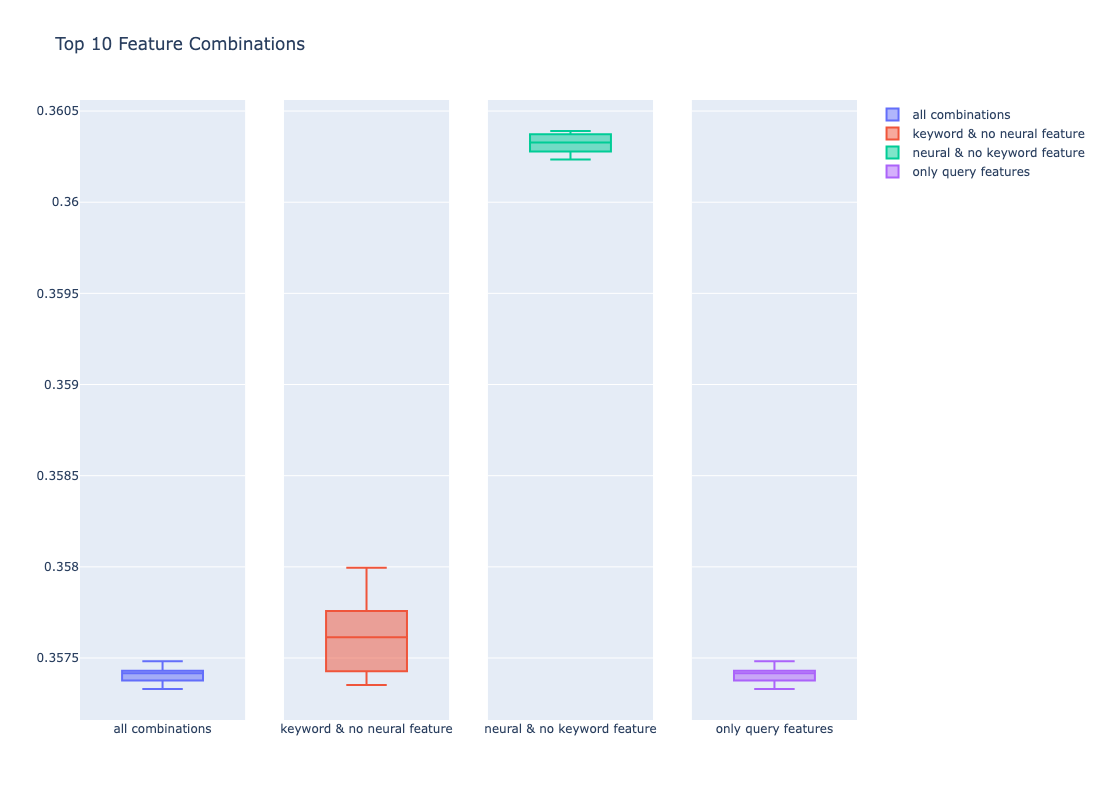

In [130]:
fig = make_subplots(rows=1, cols=4, shared_yaxes=True)

fig.add_trace(go.Box(y=df_agg_metrics.sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                     name="all combinations"),
              row=1, col=1)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['keyword_f'] == True) & (df_agg_metrics['neural_f'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="keyword & no neural feature"),
              row=1, col=2)

fig.add_trace(go.Box(y=df_agg_metrics[(df_agg_metrics['neural_f'] == True) & (df_agg_metrics['keyword_f'] == False)].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="neural & no keyword feature"),
              row=1, col=3)

fig.add_trace(go.Box(y=df_agg_metrics[df_agg_metrics['query_f'] == True].sort_values(by=['mean_rmse']).head(10)['mean_rmse'],
                    name="only query features"),
              row=1, col=4)

fig.update_layout(height=800, width=1100,
                  title_text="Top 10 Feature Combinations")
fig.show()

## Train a Linear Regression Model with cross-validation

In [131]:
from sklearn.linear_model import LinearRegression

# Prepare features and target - the best feature combination based on the previous exploration
#feature_columns = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
#                   "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
feature_columns = ['f_1_num_of_terms', 'f_3_has_numbers', 'f_5_num_results', 'f_6_max_title_score', 'f_7_sum_title_scores',
                   'f_8_max_semantic_score', 'f_9_avg_semantic_score']
X = df_filtered[feature_columns]   # Select feature columns
y = df_filtered['neuralness']      # Select the target column

# Initialize cross-validation strategy
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Define the model
regr = LinearRegression()

# Perform cross-validation
scores = cross_val_score(regr, X, y, cv=cv)
rmse_scorer = make_scorer(root_mean_squared_error)

rmse_scores = cross_val_score(regr, X, y, cv=cv, scoring=rmse_scorer)

# Output the results
print("Accuray:", scores.mean())
print("Standard deviation:", scores.std())
print("Cross-Validation Root Mean Squared Error:", np.mean(rmse_scores))

tqdm_notebook(regr.fit(X_train, y_train))

y_regr_pred = regr.predict(X_test)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_regr_pred)
r2 = r2_score(y_test, y_regr_pred)

print("Root Mean Squared Error:", rmse)
print("R^2 Score:", r2)

Accuray: 0.019969559421601925
Standard deviation: 0.006413187657428877
Cross-Validation Root Mean Squared Error: 0.35732986866789085


0it [00:00, ?it/s]

Root Mean Squared Error: 0.3608906958271416
R^2 Score: 0.019703062004301497


In [ ]:
0.35732986866789085

In [132]:
all_features = [ "f_1_num_of_terms", "f_2_query_length", "f_3_has_numbers", "f_4_has_special_char", "f_5_num_results",
                "f_6_max_title_score", "f_7_sum_title_scores", "f_8_max_semantic_score",  "f_9_avg_semantic_score"]
vector = [[3, 21, 0, 0, 22, 1.239339, 3.411745, 0.600457, 0.550430]]

df_test = pd.DataFrame(vector, columns=all_features)
df_test

,f_1_num_of_terms,f_2_query_length,f_3_has_numbers,f_4_has_special_char,f_5_num_results,f_6_max_title_score,f_7_sum_title_scores,f_8_max_semantic_score,f_9_avg_semantic_score
0,3,21,0,0,22,1.239339,3.411745,0.600457,0.55043


In [133]:
model.predict(df_test)

array([0.443])

In [134]:
regr.predict(df_test)

array([0.63378473])

In [116]:
X_test.shape[0]

1000

In [136]:
X_test.index

Index([1501, 2586, 2653, 1055,  705,  106,  589, 2468, 2413, 1600,
       ...
        944, 1268, 4231, 2307, 4424, 4711, 2313, 3214, 2732, 1926],
      dtype='int64', length=1000)

In [137]:
# Store the test data
df_filtered.loc[df_filtered.index.isin(X_test.index)].to_csv('dynamic_optimizer_test_data.csv', index=False)

## Save Models

In [138]:
import pickle

with open('regression_model.pkl', 'wb') as fid:
    pickle.dump(regr, fid) 

with open('random_forest_model.pkl', 'wb') as fid:
    pickle.dump(model, fid) 